<a href="https://colab.research.google.com/github/Sareeta-Mugde/Autoencoder/blob/master/FineTunedAutoEncoderonNoisyMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

70000  dae train samples
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 784)               0         
_________________________________________________________________
dense1 (Dense)               (None, 1024)              803840    
_________________________________________________________________
dense2 (Dense)               (None, 1024)              1049600   
_________________________________________________________________
dense3 (Dense)               (None, 1024)              1049600   
_________________________________________________________________
dense_dec (Dense)            (None, 784)               803600    
Total params: 3,706,640
Trainable params: 3,706,640
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
70000/70000 [==============================] - 56s 803us/step - loss: 0.2512
Ep

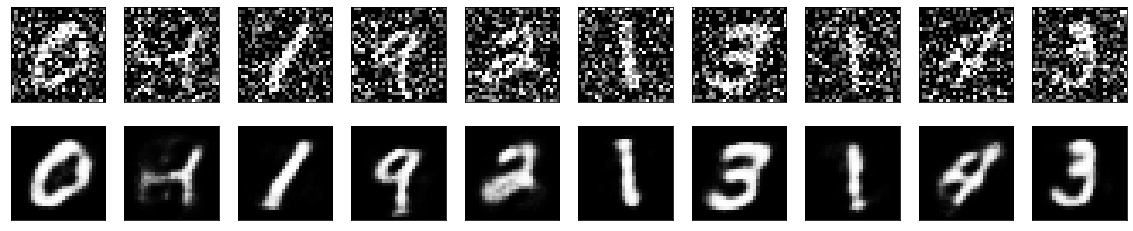

(60000, 3072)  train samples shape
(10000, 3072)  train samples shape
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 3072)              0         
_________________________________________________________________
dense1 (Dense)               (None, 1024)              3146752   
_________________________________________________________________
dense2 (Dense)               (None, 1024)              1049600   
_________________________________________________________________
dense3 (Dense)               (None, 1024)              1049600   
_________________________________________________________________
pred (Dense)                 (None, 10)                10250     
Total params: 5,256,202
Trainable params: 5,256,202
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 sam

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import (Input, Dense, Concatenate)
from keras.utils import np_utils

# Load data
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28                          
input_shape = (img_rows * img_cols, )

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_feat_train = np.concatenate((x_train, x_test), axis=0)
x_feat_train_noisy = np.concatenate((x_train_noisy, x_test_noisy), axis=0)

print(x_feat_train_noisy.shape[0], ' dae train samples')
    
def DEEP_DAE(features_shape, act='relu'):

    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Encoder / Decoder
    o = Dense(1024, activation=act, name='dense1')(o)
    o = Dense(1024, activation=act, name='dense2')(o)
    o = Dense(1024, activation=act, name='dense3')(o)
    dec = Dense(784, activation='sigmoid', name='dense_dec')(o)
    
    # Print network summary
    Model(inputs=x, outputs=dec).summary()
    
    return Model(inputs=x, outputs=dec)

batch_size = 128
epochs = 10
             
autoenc = DEEP_DAE(input_shape)
autoenc.compile(optimizer='adadelta', loss='binary_crossentropy')

autoenc.fit(x_feat_train_noisy, x_feat_train, epochs=epochs, 
            batch_size=batch_size, shuffle=True)

decoded_imgs = autoenc.predict(x_feat_train_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_feat_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

def FEATURES(model):
    input_ = model.get_layer('inputs').input
    feat1 = model.get_layer('dense1').output
    feat2 = model.get_layer('dense2').output
    feat3 = model.get_layer('dense3').output
    feat = Concatenate(name='concat')([feat1, feat2, feat3])
    model = Model(inputs=[input_],
                      outputs=[feat])
    return model

_model = FEATURES(autoenc)
features_train = _model.predict(x_train)
features_test = _model.predict(x_test)
print(features_train.shape, ' train samples shape')
print(features_test.shape, ' train samples shape')

def DNN(features_shape, num_classes, act='relu'):

    # Input
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Encoder / Decoder
    o = Dense(1024, activation=act, name='dense1')(o)
    o = Dense(1024, activation=act, name='dense2')(o)
    o = Dense(1024, activation=act, name='dense3')(o)
    y_pred = Dense(num_classes, activation='sigmoid', name='pred')(o)
    
    # Print network summary
    Model(inputs=x, outputs=y_pred).summary()
    
    return Model(inputs=x, outputs=y_pred)

input_shape2 = (features_train.shape[1], )
num_classes = 10

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
 
batch_size = 128
epochs = 10
model_fname = 'dnn'

callbacks = [ModelCheckpoint(monitor='val_acc', filepath=model_fname + '.hdf5',
                             save_best_only=True, save_weights_only=True,
                             mode='min')]
            
deep = DNN(input_shape2, num_classes)
deep.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])

history = deep.fit(features_train, y_train_ohe, epochs=epochs, 
                   batch_size=batch_size, shuffle=True,
                   validation_data=(features_test, y_test_ohe), 
                   callbacks=callbacks)

# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
deep.load_weights(model_fname + '.hdf5')
predictions = deep.predict(features_test)
predicted_classes = np.argmax(predictions, axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

http://dkopczyk.quantee.co.uk/dae-part3/ 